## DATA IMPORT

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

train_data = pd.read_csv('data/train.csv')
print('Training data set: ' + str(len(train_data)))

#train_data.head()

Training data set: 1306122


## DATA WRANGLING

In [26]:
%%time

import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
#nltk.download()
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet
from nltk.corpus import stopwords 
from joblib import dump
from joblib import load

stop_words = set(stopwords.words('english'))

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def porter_stemmer(text): #PorterStemmer
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text): 
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def remove_stop_word(text): 
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stop_words])
    return text

train_data['origin'] = train_data['question_text']
train_data['question_text'] = train_data['question_text'].str.normalize('NFKD')\
.apply(remove_non_ascii).apply(remove_white_space).apply(contractions.fix).str.lower()\
.apply(remove_special_character).apply(remove_stop_word)

train_data['question_text_stem'] = train_data['question_text'].apply(porter_stemmer)
train_data['question_text_lemma'] = train_data['question_text'].apply(lemmatizer)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))
train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
#print(train_data.head())

filename = 'train_data.sav'
dump(train_data, filename)

[nltk_data] Downloading package punkt to /Users/yang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Training data set: 1306020
CPU times: user 30min 52s, sys: 1min 29s, total: 32min 21s
Wall time: 2h 39min 25s


## WORD CLOUD 

Just for fun, from <B>[Generating WordClouds in Python](https://www.datacamp.com/community/tutorials/wordcloud-python)</B>

In [27]:
from joblib import dump
from joblib import load
filename = 'train_data.sav'
train_data = load(filename)
print('Training data set: ' + str(len(train_data)))

Training data set: 1306020


In [28]:
#?WordCloud

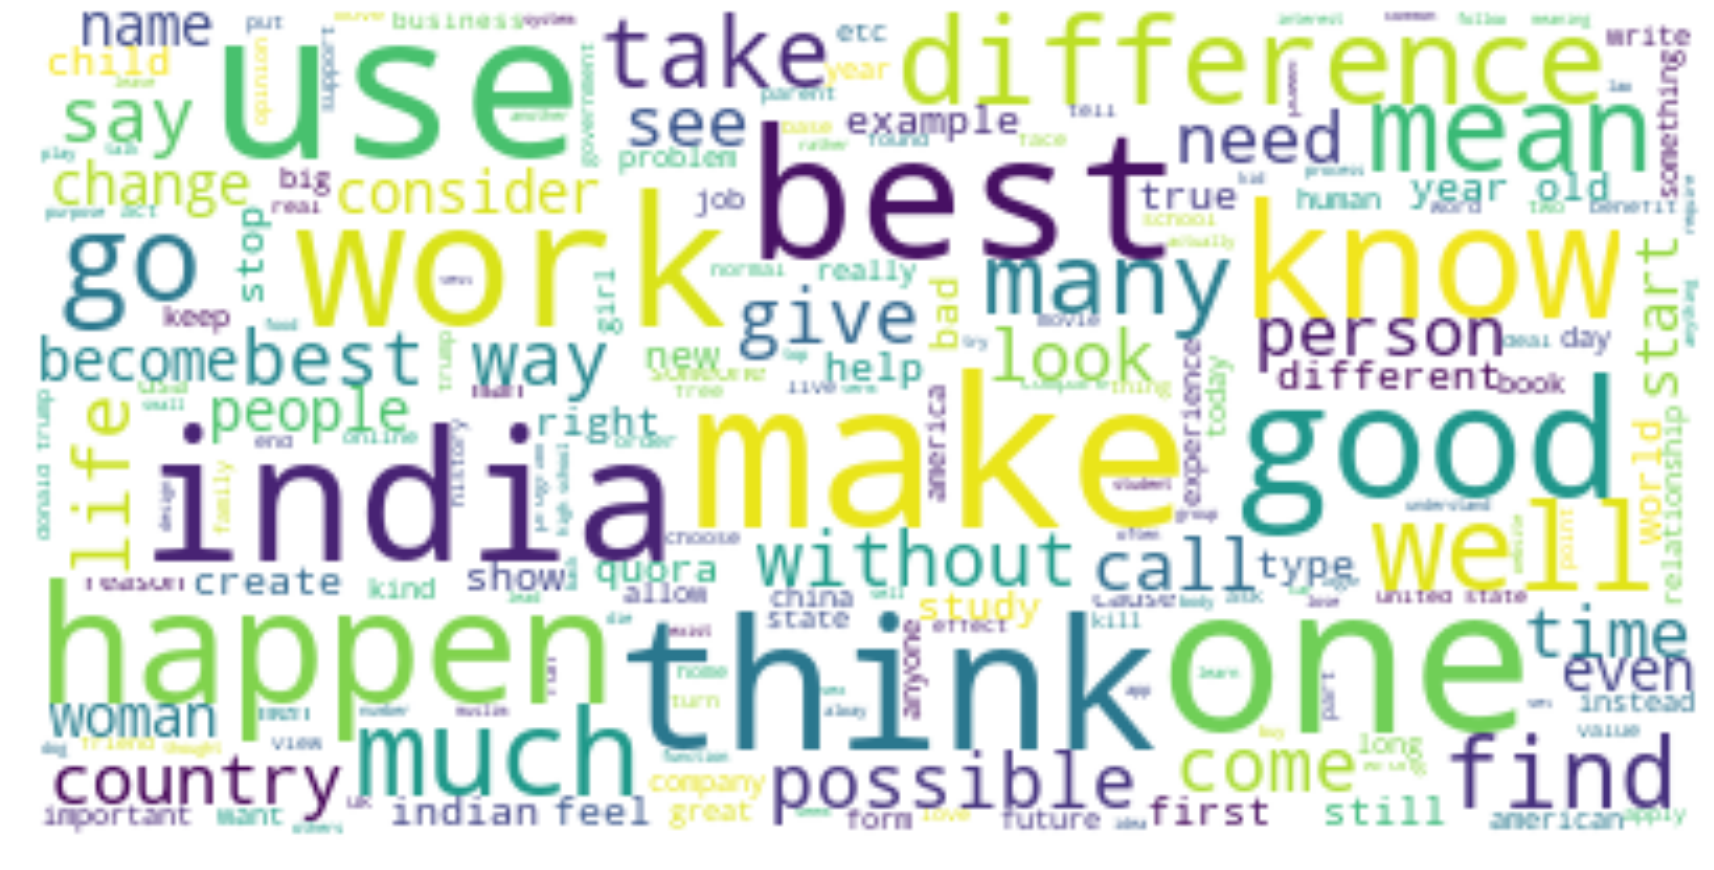

In [29]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

#train_data[["question_text", "question_text_stem","question_text_lemma"]].head()

text = " ".join(question for question in train_data.question_text_lemma)
plt.figure(figsize=(30,20))
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("image/all_words.png")

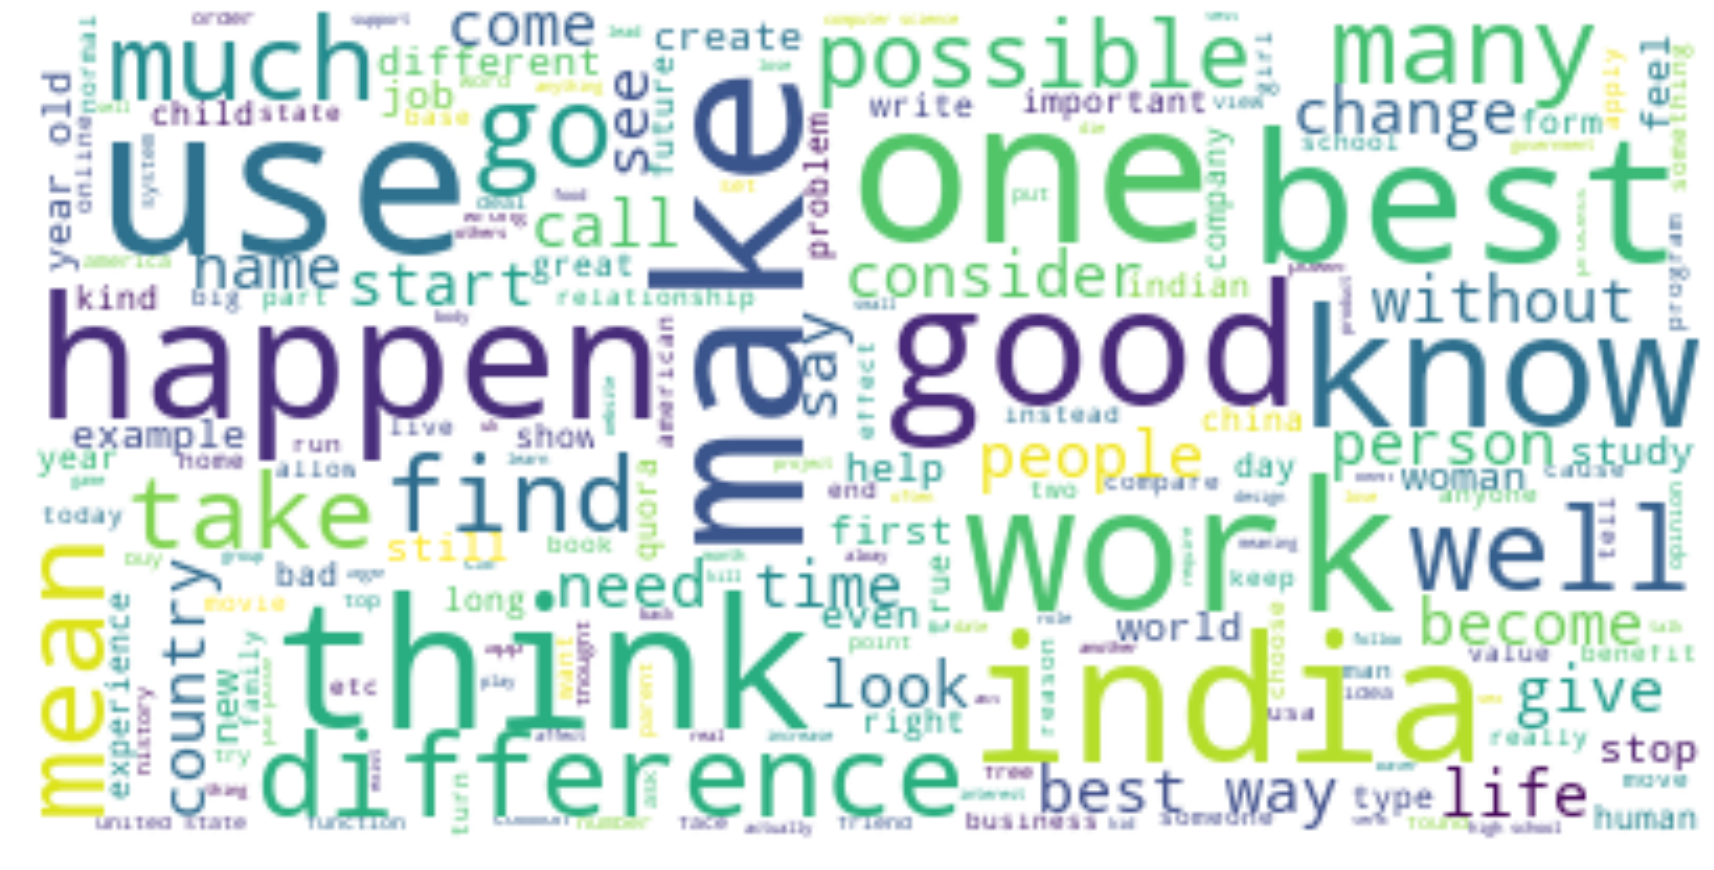

In [30]:
text = " ".join(question for question in train_data.loc[train_data.target == 0,'question_text_lemma'])
plt.figure(figsize=(30,20))
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("image/positive_words.png")

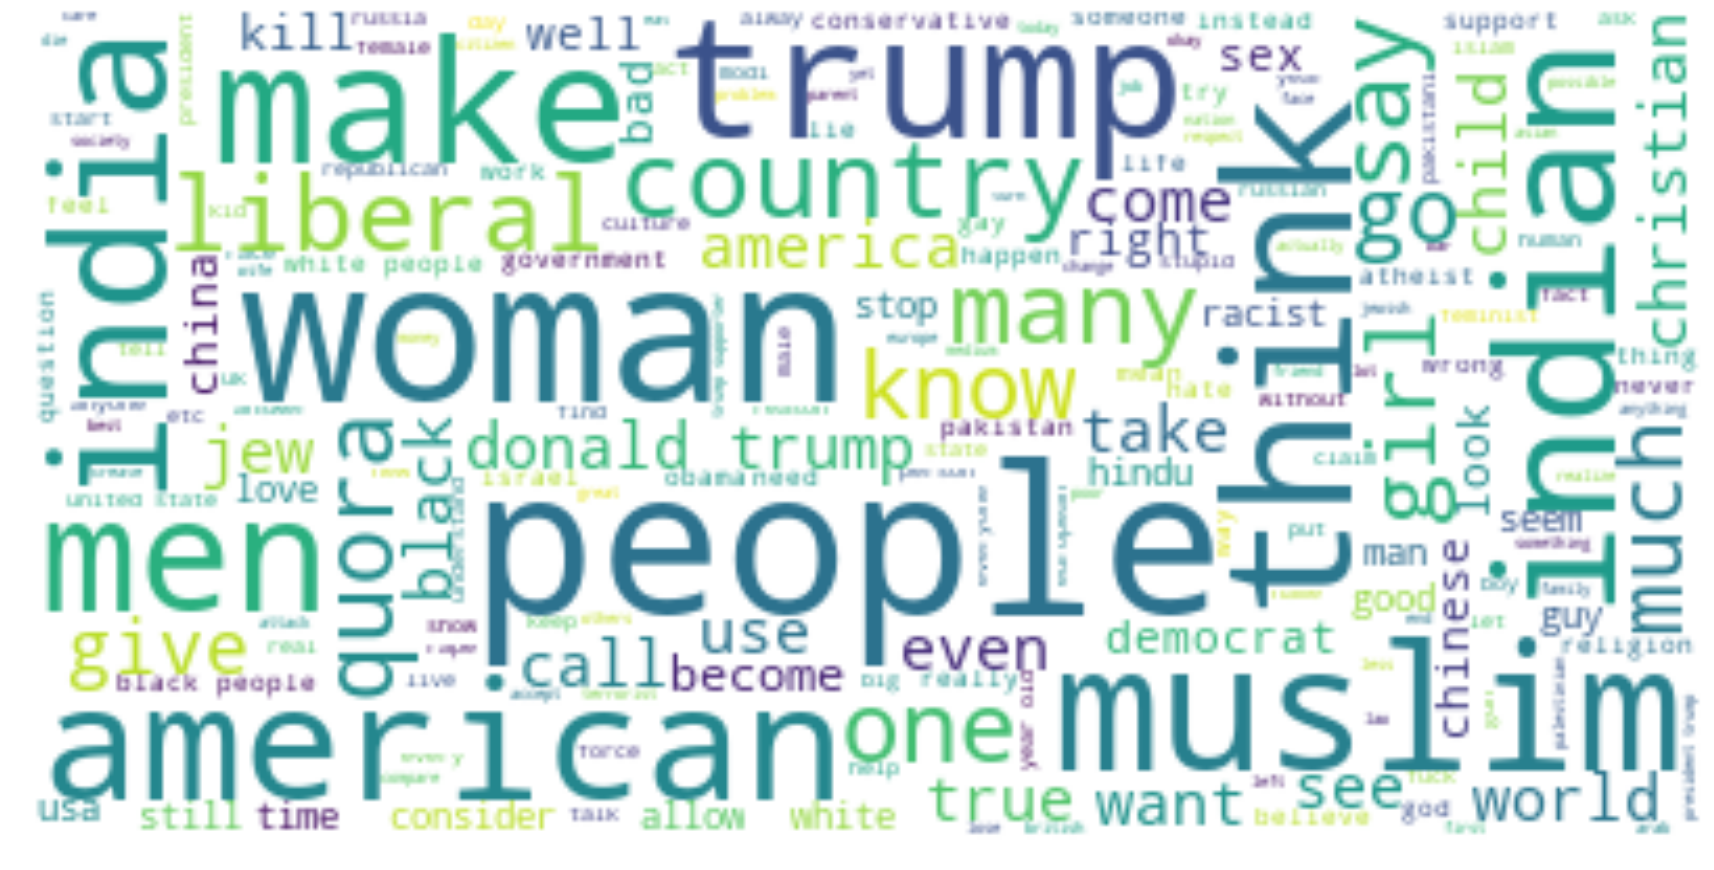

In [31]:
text = " ".join(question for question in train_data.loc[train_data.target == 1,'question_text_lemma'])
plt.figure(figsize=(30,20))
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("image/negative_words.png")

## TRAIN-TEST DATA PREPARATOIN 

In [24]:
%%time

#split dataset tf-idf & count 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from joblib import dump
from joblib import load

train_text_lemma = train_data['question_text_lemma']
train_target = train_data['target']

train_text_stem = train_data['question_text_stem']
train_target = train_data['target']

count_vectorizer_lemma = CountVectorizer()
count_vectorizer_lemma.fit_transform(train_text_lemma)
filename = 'count_vectorizer_lemma.sav'
dump(count_vectorizer_lemma,filename)

count_vectorizer_stem = CountVectorizer()
count_vectorizer_stem.fit_transform(train_text_lemma)
filename = 'count_vectorizer_stem.sav'
dump(count_vectorizer_stem,filename)


tfidf_vectorizer_lemma = TfidfVectorizer()
tfidf_vectorizer_lemma.fit_transform(train_text_lemma)
filename = 'tfidf_vectorizer_lemma.sav'
dump(tfidf_vectorizer_lemma,filename)

tfidf_vectorizer_stem = TfidfVectorizer()
tfidf_vectorizer_stem.fit_transform(train_text_lemma)
filename = 'tfidf_vectorizer_stem.sav'
dump(tfidf_vectorizer_stem,filename)


CPU times: user 1min 3s, sys: 1.34 s, total: 1min 4s
Wall time: 1min 3s


## Bag Of Words Using Traiditonal Machine Learning 

### Grid Search for Algorithm (BernoulliNB)

In [ ]:
%%time

import datetime, time, psutil, os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from joblib import dump
from joblib import load

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
param_grid = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':np.arange(1,20, 2),
          'min_samples_split': np.arange(2,20, 2),'min_samples_leaf': np.arange(1,20,2)}

estimator = DecisionTreeClassifier()
search = GridSearchCV(estimator, param_grid, cv=5)
search.fit(X_train,y_train)

# the best tree
filename = 'tree.sav'
best_tree = search.best_estimator_ 
best_tree.fit(X_train,y_train)
dump(best_tree, filename)
best_tree = load(filename)

# Attributes: cv_results_ , best_estimator_,  best_score_, best_params_
print(search.best_estimator_)
print('\n')
print(search.best_score_)
print('\n')
print(search.best_params_)
print('\n')
print(best_tree)


# report
train_predicted = best_tree.predict(X_train)
test_predicted = best_tree.predict(X_test)

target_names = ['Bad', 'Good']
train_report = classification_report(y_train,train_predicted, target_names=target_names,output_dict=False)
test_report = classification_report(y_test,test_predicted, target_names=target_names, output_dict=False)

print(train_report)
print('\n')
print(test_report)

model_compare['decision_tree_train'] =train_report
model_compare['decision_tree_test'] =test_report


### Grid Search for Algorithm (Logistic Regression)

### Grid Search for Algorithm (SVM)

### Grid Search for Algorithm (RandomForestClassifier)

### Grid Search for Algorithm (GradientBoostingClassifier)

## Classification Result Comparsion

### Apply Both CountVector and TfIdfVector,  Accuracy Reporting Using Confusion Matrix
<B>use classifier.predict instead of classifier.predict_proba in baseline for confusion matrix</B>

In [40]:
from sklearn.model_selection import train_test_split
train_text = train_data['question_text']
test_text = test_data['question_text']
train_target = train_data['target']
all_text = train_text.append(test_text)
X_train, X_test, y_train, y_test = train_test_split(train_text, train_target, test_size=0.20, random_state = 0)

In [48]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer
import xgboost as xgb

# apply both cont vector & tf-idf vector 
count_vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

# from X_train -> X_train_counts -> X_train_tfidf
X_train_count = count_vectorizer.fit_transform(train_text)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

# fit model
data_dmatrix = xgb.DMatrix(data=X_train_tfidf,label=train_target)
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


CPU times: user 35.7 s, sys: 66.4 ms, total: 35.8 s
Wall time: 35.3 s


In [42]:
%%time

#GradientBoostingClassifier

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
test_preds = 0
oof_preds = np.zeros([train_data.shape[0],])

for i, (train_idx,valid_idx) in enumerate(kfold.split(train_data)):
    x_train, x_valid = train_text_features[train_idx,:], train_text_features[valid_idx,:]
    y_train, y_valid = train_target[train_idx], train_target[valid_idx]
    classifier = GradientBoostingClassifier(random_state=1)
    classifier.fit(x_train,y_train)
   
    oof_preds[valid_idx] = classifier.predict_proba(x_valid)[:,1]

pred_train = (oof_preds > 0.25).astype(np.int)
accuracy = f1_score(train_target, pred_train)
print(accuracy)

0.4322752985543683
CPU times: user 1h 8min 41s, sys: 10 s, total: 1h 8min 51s
Wall time: 1h 4min 3s


In [49]:
print(cv_results)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          0.461173        0.000032        0.461185       0.000036
1          0.427029        0.000235        0.427175       0.000217
2          0.397172        0.000106        0.397254       0.000277
3          0.371091        0.000274        0.371254       0.000605
4          0.348466        0.000230        0.348574       0.000577
5          0.328740        0.000386        0.329129       0.000745
6          0.312035        0.000404        0.312331       0.000746
7          0.297388        0.000464        0.297825       0.000858
8          0.284917        0.000524        0.285430       0.000953
9          0.274351        0.000523        0.274964       0.001002
10         0.265442        0.000604        0.266148       0.000989
11         0.257756        0.000533        0.258513       0.001110
12         0.251383        0.000545        0.252176       0.001210
13         0.246173        0.000539        0.246979       0.00

In [50]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [44]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# apply both cont vector & tf-idf vector 
count_vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

# from X_train -> X_train_counts -> X_train_tfidf
X_train_count = count_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

# fit model
classifier1 = BernoulliNB().fit(X_train_tfidf, y_train)
classifier2 = LogisticRegression(solver='liblinear').fit(X_train_tfidf,y_train)
classifier3 = GradientBoostingClassifier(random_state=1).fit(X_train_tfidf,y_train)

X_test_count = count_vectorizer.transform(X_test)
x_test_tfidf = tfidf_transformer.transform(X_test_count)

y_pred1 = classifier1.predict(x_test_tfidf)
y_pred2 = classifier2.predict(x_test_tfidf)
y_pred3 = classifier3.predict(x_test_tfidf)

CPU times: user 1min 28s, sys: 523 ms, total: 1min 29s
Wall time: 28.4 s


[[24203   205]
 [ 1339   374]]
[[24210   198]
 [ 1286   427]]
[[24320    88]
 [ 1472   241]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97     24408
           1       0.65      0.22      0.33      1713

   micro avg       0.94      0.94      0.94     26121
   macro avg       0.80      0.60      0.65     26121
weighted avg       0.93      0.94      0.93     26121

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     24408
           1       0.68      0.25      0.37      1713

   micro avg       0.94      0.94      0.94     26121
   macro avg       0.82      0.62      0.67     26121
weighted avg       0.93      0.94      0.93     26121

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     24408
           1       0.73      0.14      0.24      1713

   micro avg       0.94      0.94      0.94     26121
   macro avg       0.84      0.57

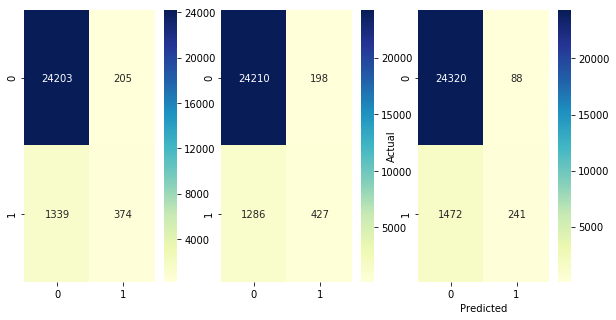

In [45]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat1 = confusion_matrix(y_test, y_pred1)
conf_mat2 = confusion_matrix(y_test, y_pred2)
conf_mat3 = confusion_matrix(y_test, y_pred3)

print(conf_mat1)  
print(conf_mat2)  
print(conf_mat3)  
print('\n')
print(classification_report(y_test,y_pred1))  
print(classification_report(y_test,y_pred2))  
print(classification_report(y_test,y_pred3))  
print('\n')
print(accuracy_score(y_test, y_pred1))  
print(accuracy_score(y_test, y_pred2))  
print(accuracy_score(y_test, y_pred3))  
print('\n')

fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True)
sns.heatmap(conf_mat1, annot=True, fmt='d', cmap="YlGnBu", ax=axes[0])
sns.heatmap(conf_mat2, annot=True, fmt='d', cmap="YlGnBu", ax=axes[1])
sns.heatmap(conf_mat3, annot=True, fmt='d', cmap="YlGnBu", ax=axes[2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()